# News Analytics and Stock Price Performance: Feature Preprocessing, Exploration and Engineering (part 2)
------

Can we use news analytics and market data to predict stock price performance? There is no doubt that the ubiquity of data today enables investors at any scale to make better investment decisions but to truly harness this power, we must be able to distinguish signal from noise.

This is a 3 part walkthrough of a Kaggle competition by Two Sigma, with the end result being a model that predicts a signed confidence of an assets fluctuation over a ten-day window.

$$\widehat{y}_{ti}\in[-1, 1]$$

Initially, I was a little confused with the evaluation process here.  Most people think of stock market predictions as being regression problems but this seemed like a binary classification problem to me.  An asset either has a positive or a negative return, with the signed confidence being used to indicate both the direction and the magnitude of this move.

as mentioned above, the signed confidence interval needs to be between [-1 and 1].  Binary classification models are going to output a probability, naturally being a number between 0 and 1.  So in order to get the output of my model to conform to this structure, I decided I would multiply my predicted value by 2 and then subtract 1.  If the predicted probability is 0, this will cause the output to be -1 and if the predicted probability is 1, then the output will be 1.


For each day in the evaluation time period, we calculate:
$$x_{t}=\sum_{i}\widehat{y}_{ti}r_{ti}u_{ti}$$
$$score=\frac{\bar{x}_{t}}{\sigma (x_{t})}$$

where $r_{ti}$ is the 10-day market-adjusted leading return for day $t$ for instrument $i$, and $u_{ti}$ is a 0/1 universe variable that controls whether a particular asset is included in scoring on a particular day.

Your submission score is then calculated as the mean divided by the standard deviation of your daily $x_{t}$ values:

If the standard deviation of predictions is 0, the score is defined as 0.

Two sources of data for this competition:

Market data (2007 to present) provided by Intrinio - contains financial market information such as opening price, closing price, trading volume, calculated returns, etc.

News data (2007 to present) Source: Thomson Reuters - contains information about news articles/alerts published about assets, such as article details, sentiment, and other commentary.

There are 3 notebooks for this walkthrough.  The first includes all of the EDA for both datasets.  In the second, I walk through feature preprocessing, exploration and engineering.  Finally, in the third notebook,  I build, test and tune multiple machine learning models.

In [1]:
import numpy as np
import pandas as pd
import os
from kaggle.competitions import twosigmanews
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns; sns.set()
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler
from sklearn import ensemble
from sklearn.metrics import accuracy_score
import scipy.stats as stats
from sklearn.feature_extraction.text import TfidfVectorizer
import category_encoders as ce
import warnings
import gc
import psutil 
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
def cpuStats():
    pid = os.getpid()
    py = psutil.Process(pid)
    memoryUse = py.memory_info()[0] / 2. ** 30
    return 'memory GB:' + str(np.round(memoryUse, 2))

In [3]:
cpuStats()

'memory GB:0.25'

In [4]:
# Load training data from API
env = twosigmanews.make_env()
(market_train_df, news_train_df) = env.get_training_data()

Loading the data... This could take a minute.
Done!


In [5]:
cpuStats()

'memory GB:7.04'

As you can see, I have no control over how the data is imported and after doing so, I lose half of my available RAM.  The two *market_train_df* and *news_train_df* files are stored in the Kaggle environment in feather format. 

In [6]:
!cat {twosigmanews.__file__}

# AUTO-GENERATED FILE, DO NOT MODIFY
"""kaggle.competitions.twosigmanews package

Provides a helper function to create an environment which facilitates
participation in the Two Sigma Financial News Challenge competition.
"""

from kaggle.competitions.twosigmanews import env


def make_env():
    """Returns a new environment supporting the Two Sigma News competition."""
    return env.TwoSigmaNewsEnv()
    
__all__ = ['make_env']


In [7]:
market_train_df.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4072956 entries, 0 to 4072955
Data columns (total 16 columns):
time                        4072956 non-null datetime64[ns, UTC]
assetCode                   4072956 non-null object
assetName                   4072956 non-null category
volume                      4072956 non-null float64
close                       4072956 non-null float64
open                        4072956 non-null float64
returnsClosePrevRaw1        4072956 non-null float64
returnsOpenPrevRaw1         4072956 non-null float64
returnsClosePrevMktres1     4056976 non-null float64
returnsOpenPrevMktres1      4056968 non-null float64
returnsClosePrevRaw10       4072956 non-null float64
returnsOpenPrevRaw10        4072956 non-null float64
returnsClosePrevMktres10    3979946 non-null float64
returnsOpenPrevMktres10     3979902 non-null float64
returnsOpenNextMktres10     4072956 non-null float64
universe                    4072956 non-null float64
dtypes: category(1), dateti

In [8]:
news_train_df.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9328750 entries, 0 to 9328749
Data columns (total 35 columns):
time                    9328750 non-null datetime64[ns, UTC]
sourceTimestamp         9328750 non-null datetime64[ns, UTC]
firstCreated            9328750 non-null datetime64[ns, UTC]
sourceId                9328750 non-null object
headline                9328750 non-null object
urgency                 9328750 non-null int8
takeSequence            9328750 non-null int16
provider                9328750 non-null category
subjects                9328750 non-null category
audiences               9328750 non-null category
bodySize                9328750 non-null int32
companyCount            9328750 non-null int8
headlineTag             9328750 non-null object
marketCommentary        9328750 non-null bool
sentenceCount           9328750 non-null int16
wordCount               9328750 non-null int32
assetCodes              9328750 non-null category
assetName               9328750 no

We can see that these are two fairly large DataFrames.  Some of the features are imported with specific types that are memory heavy, such as dates.  I do not have control over this.

In [9]:
print(f'market_train_df: {market_train_df.shape}')
market_train_df.head()

market_train_df: (4072956, 16)


,time,assetCode,assetName,volume,close,open,returnsClosePrevRaw1,returnsOpenPrevRaw1,returnsClosePrevMktres1,returnsOpenPrevMktres1,returnsClosePrevRaw10,returnsOpenPrevRaw10,returnsClosePrevMktres10,returnsOpenPrevMktres10,returnsOpenNextMktres10,universe
0,2007-02-01 22:00:00+00:00,A.N,Agilent Technologies Inc,2606900.0,32.19,32.17,0.005938,0.005312,NaN,NaN,-0.001860,0.000622,NaN,NaN,0.034672,1.0
1,2007-02-01 22:00:00+00:00,AAI.N,AirTran Holdings Inc,2051600.0,11.12,11.08,0.004517,-0.007168,NaN,NaN,-0.078708,-0.088066,NaN,NaN,0.027803,0.0
2,2007-02-01 22:00:00+00:00,AAP.N,Advance Auto Parts Inc,1164800.0,37.51,37.99,-0.011594,0.025648,NaN,NaN,0.014332,0.045405,NaN,NaN,0.024433,1.0
3,2007-02-01 22:00:00+00:00,AAPL.O,Apple Inc,23747329.0,84.74,86.23,-0.011548,0.016324,NaN,NaN,-0.048613,-0.037182,NaN,NaN,-0.007425,1.0
4,2007-02-01 22:00:00+00:00,ABB.N,ABB Ltd,1208600.0,18.02,18.01,0.011791,0.025043,NaN,NaN,0.012929,0.020397,NaN,NaN,-0.017994,1.0


In [10]:
market_train_df.tail()

,time,assetCode,assetName,volume,close,open,returnsClosePrevRaw1,returnsOpenPrevRaw1,returnsClosePrevMktres1,returnsOpenPrevMktres1,returnsClosePrevRaw10,returnsOpenPrevRaw10,returnsClosePrevMktres10,returnsOpenPrevMktres10,returnsOpenNextMktres10,universe
4072951,2016-12-30 22:00:00+00:00,ZIOP.O,ZIOPHARM Oncology Inc,1608829.0,5.35,5.37,-0.003724,0.000000,0.000536,-0.001868,-0.165367,-0.138042,-0.139597,-0.135913,0.051189,0.0
4072952,2016-12-30 22:00:00+00:00,ZLTQ.O,ZELTIQ Aesthetics Inc,347830.0,43.52,43.62,-0.000689,0.000000,-0.000515,0.000493,0.002996,0.002989,0.008213,0.003210,-0.048555,0.0
4072953,2016-12-30 22:00:00+00:00,ZNGA.O,Zynga Inc,7396601.0,2.57,2.58,-0.011538,0.000000,-0.006004,-0.001034,-0.091873,-0.078571,-0.077252,-0.077188,0.011703,0.0
4072954,2016-12-30 22:00:00+00:00,ZTO.N,Unknown,3146519.0,12.07,12.50,-0.029743,0.007252,-0.028460,0.006719,-0.065066,-0.042146,-0.078104,-0.043813,0.083367,1.0
4072955,2016-12-30 22:00:00+00:00,ZTS.N,Zoetis Inc,1701204.0,53.53,53.64,-0.001678,0.003091,0.005060,0.002885,0.023127,0.028177,0.026566,0.028719,-0.016220,1.0


In [11]:
print(f'news_train_df: {news_train_df.shape}')
news_train_df.head()

news_train_df: (9328750, 35)


,time,sourceTimestamp,firstCreated,sourceId,headline,urgency,takeSequence,provider,subjects,audiences,bodySize,companyCount,headlineTag,marketCommentary,sentenceCount,wordCount,assetCodes,assetName,firstMentionSentence,relevance,sentimentClass,sentimentNegative,sentimentNeutral,sentimentPositive,sentimentWordCount,noveltyCount12H,noveltyCount24H,noveltyCount3D,noveltyCount5D,noveltyCount7D,volumeCounts12H,volumeCounts24H,volumeCounts3D,volumeCounts5D,volumeCounts7D
0,2007-01-01 04:29:32+00:00,2007-01-01 04:29:32+00:00,2007-01-01 04:29:32+00:00,e58c6279551b85cf,China's Daqing pumps 43.41 mln tonnes of oil i...,3,1,RTRS,"{'ENR', 'ASIA', 'CN', 'NGS', 'EMRG', 'RTRS', '...","{'Z', 'O', 'OIL'}",1438,1,,False,11,275,"{'0857.HK', '0857.F', '0857.DE', 'PTR.N'}",PetroChina Co Ltd,6,0.235702,-1,0.500739,0.419327,0.079934,73,0,0,0,0,0,0,0,3,6,7
1,2007-01-01 07:03:35+00:00,2007-01-01 07:03:34+00:00,2007-01-01 07:03:34+00:00,5a31c4327427f63f,"FEATURE-In kidnapping, finesse works best",3,1,RTRS,"{'FEA', 'CA', 'LATAM', 'MX', 'INS', 'ASIA', 'I...","{'PGE', 'PCO', 'G', 'ESN', 'MD', 'PCU', 'DNP',...",4413,1,FEATURE,False,55,907,{'STA.N'},Travelers Companies Inc,8,0.447214,-1,0.600082,0.345853,0.054064,62,1,1,1,1,1,1,1,3,3,3
2,2007-01-01 11:29:56+00:00,2007-01-01 11:29:56+00:00,2007-01-01 11:29:56+00:00,1cefd27a40fabdfe,PRESS DIGEST - Wall Street Journal - Jan 1,3,1,RTRS,"{'RET', 'ENR', 'ID', 'BG', 'US', 'PRESS', 'IQ'...","{'T', 'DNP', 'PSC', 'U', 'D', 'M', 'RNP', 'PTD...",2108,2,PRESS DIGEST,False,15,388,"{'WMT.DE', 'WMT.N'}",Wal-Mart Stores Inc,14,0.377964,-1,0.450049,0.295671,0.254280,67,0,0,0,0,0,0,0,5,11,17
3,2007-01-01 12:08:37+00:00,2007-01-01 12:08:37+00:00,2007-01-01 12:08:37+00:00,23768af19dc69992,PRESS DIGEST - New York Times - Jan 1,3,1,RTRS,"{'FUND', 'FIN', 'CA', 'SFWR', 'INS', 'PUB', 'B...","{'T', 'DNP', 'PSC', 'U', 'D', 'M', 'RNP', 'PTD...",1776,6,PRESS DIGEST,False,14,325,"{'GOOG.O', 'GOOG.OQ', 'GOOGa.DE'}",Google Inc,13,0.149071,-1,0.752917,0.162715,0.084368,83,0,0,0,0,0,0,0,5,13,15
4,2007-01-01 12:08:37+00:00,2007-01-01 12:08:37+00:00,2007-01-01 12:08:37+00:00,23768af19dc69992,PRESS DIGEST - New York Times - Jan 1,3,1,RTRS,"{'FUND', 'FIN', 'CA', 'SFWR', 'INS', 'PUB', 'B...","{'T', 'DNP', 'PSC', 'U', 'D', 'M', 'RNP', 'PTD...",1776,6,PRESS DIGEST,False,14,325,{'XMSR.O'},XM Satellite Radio Holdings Inc,11,0.149071,-1,0.699274,0.209360,0.091366,102,0,0,0,0,0,0,0,0,0,0


## Chi2 for assetCode

In [12]:
column = 'assetCode'
y = market_train_df['returnsOpenNextMktres10'] > 0
print(market_train_df[column].nunique())

cont = pd.crosstab(market_train_df.iloc[:2500][column], y[:2500])
chi2_res = stats.chi2_contingency(cont)
print(chi2_res[1])

cont = pd.crosstab(market_train_df[column], y)
chi2_res = stats.chi2_contingency(cont)
print(chi2_res[1])

3780
2.5696864141804518e-33
0.0


Considering the size of these DataFrames, let’s run a chi2 test on the *assetCode* feature to see if it's statistically significant.  This may have been a redundant step considering I am dealing with millions of instances and with larger datasets, the P-value will likely start to drift towards a significant value.

Since *assetCode* appears to be statistically significant, I will encode it.

## Helper Functions

Below is a list of helper functions I wrote to keep my code DRY.  One thing I have learned from being a software developer is that whenever you find yourself repeating code, create a function.  This can go into a toolbox and be used not only across the current application but also across multiple projects.

In [13]:
def label_cat(df, col):
    return df[col].astype('category').cat.as_ordered()

def bin_encode(df, cols_to_bin):
    ce_bin = ce.BinaryEncoder(cols = cols_to_bin)
    return ce_bin.fit_transform(df)

# Find all features with NaN's
def get_null_features(df):
    return df.columns[df.isna().any()].tolist()

# Returns either month, day or year of date -> expedites feature engineering 
def get_date_feature(df, col, date_type):
    if (date_type == 'year'):
        return pd.to_datetime(df[col]).dt.year
    elif (date_type == 'month'):
        return pd.to_datetime(df[col]).dt.month
    elif (date_type == 'quarter'):
        return pd.to_datetime(df[col]).dt.quarter
    else:
        return pd.to_datetime(df[col]).dt.dayofweek

# Helper function to print accuracy
def print_accuracy(model, x, y, x_val, y_val):
    print("Training Accuracy Score: ", accuracy_score(model.predict(x), y))
    print("Validation Accuracy Score: ", accuracy_score(model.predict(x_val), y_val))
    
# Helper function to get feature importances
def get_feature_imp(model, x):
    return pd.DataFrame(model.feature_importances_,
                                   index = x.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)

# Calculate the RSI
def RSI(series, period):
    delta = series.diff().dropna()
    u = delta * 0
    d = u.copy()
    u[delta > 0] = delta[delta > 0]
    d[delta < 0] = -delta[delta < 0]
    u[u.index[period-1]] = np.mean( u[:period] ) #first value is sum of avg gains
    u = u.drop(u.index[:(period-1)])
    d[d.index[period-1]] = np.mean( d[:period] ) #first value is sum of avg losses
    d = d.drop(d.index[:(period-1)])
    rs = u.ewm(com=period-1, adjust=False).mean() / d.ewm(com=period-1, adjust=False).mean()
    return 100 - 100 / (1 + rs)

# 80%, 20%
def temploral_split(df, label):
    train, validate = np.split(df, [int(.8*len(df))])
    
    X_train = train.loc[:, ~train.columns.isin([label])]
    y_train = train[label] > 0
    
    X_val = validate.loc[:, ~validate.columns.isin([label])]
    y_val = validate[label] > 0
    
    return [X_train, y_train, X_val, y_val]

# Join 2 dataframes
def join_df(left, right, left_on, right_on=None, suffix='_y'):
    if right_on is None: right_on = left_on
    return left.merge(right, how='left', left_on=left_on, right_on=right_on, 
                      suffixes=("", suffix))

## Experimenting with Just Market Data

Since stock market predictions have historically and primarily been based on historical market data itself, I wanted to start with just market data and see if the added news data contribute anything significant.

In [14]:
# Store this for join later on
tmpAssetCode = market_train_df['assetCode'].values
tmpMarketDates = market_train_df.time.dt.strftime("%Y%m%d").astype(int)

## Handling Categorical Features

In [15]:
# Handle categorical variables
market_train_df['assetCode_cat'] = label_cat(market_train_df, 'assetCode').cat.codes

# I experimented with both label encoding and binary encoding
# market_train_df = bin_encode(market_train_df, ['assetCode'])

I experimented with both label encoding as well as binary encoding.  I found that I was getting better results with label encoding.  One-hot-encoding is probably not the best approach here considering the high cardinality of the *assetCode* feature, having thousands of unique values.

In [16]:
market_train_df['assetCode_cat'][0:5]

0     0
1     2
2     7
3     8
4    15
Name: assetCode_cat, dtype: int16

In [17]:
# Drop
market_train_df.drop(['assetCode', 'assetName', 'universe'], axis=1, inplace=True)

Since we label encoded *assetCode*, the *assetName* feature is somewhat redundant now.

## Handling Dates

Let’s do some feature engineering with the date columns.  I’ll start with the day of week and month.

In [18]:
# Create year, month, day features
market_train_df['month'] = get_date_feature(market_train_df, 'time', 'month')
market_train_df['day'] = get_date_feature(market_train_df, 'time', 'day')
market_train_df['quarter'] = get_date_feature(market_train_df, 'time', 'quarter')

# Time to drop the time feature
market_train_df.drop(['time'], axis=1, inplace=True)

In [19]:
market_train_df.head()

,volume,close,open,returnsClosePrevRaw1,returnsOpenPrevRaw1,returnsClosePrevMktres1,returnsOpenPrevMktres1,returnsClosePrevRaw10,returnsOpenPrevRaw10,returnsClosePrevMktres10,returnsOpenPrevMktres10,returnsOpenNextMktres10,assetCode_cat,month,day,quarter
0,2606900.0,32.19,32.17,0.005938,0.005312,NaN,NaN,-0.001860,0.000622,NaN,NaN,0.034672,0,2,3,1
1,2051600.0,11.12,11.08,0.004517,-0.007168,NaN,NaN,-0.078708,-0.088066,NaN,NaN,0.027803,2,2,3,1
2,1164800.0,37.51,37.99,-0.011594,0.025648,NaN,NaN,0.014332,0.045405,NaN,NaN,0.024433,7,2,3,1
3,23747329.0,84.74,86.23,-0.011548,0.016324,NaN,NaN,-0.048613,-0.037182,NaN,NaN,-0.007425,8,2,3,1
4,1208600.0,18.02,18.01,0.011791,0.025043,NaN,NaN,0.012929,0.020397,NaN,NaN,-0.017994,15,2,3,1


## Handling Numerical features

In [20]:
market_train_df.isnull().sum()

volume                          0
close                           0
open                            0
returnsClosePrevRaw1            0
returnsOpenPrevRaw1             0
returnsClosePrevMktres1     15980
returnsOpenPrevMktres1      15988
returnsClosePrevRaw10           0
returnsOpenPrevRaw10            0
returnsClosePrevMktres10    93010
returnsOpenPrevMktres10     93054
returnsOpenNextMktres10         0
assetCode_cat                   0
month                           0
day                             0
quarter                         0
dtype: int64

In [21]:
mrkt_null = get_null_features(market_train_df)
mrkt_null

['returnsClosePrevMktres1',
 'returnsOpenPrevMktres1',
 'returnsClosePrevMktres10',
 'returnsOpenPrevMktres10']

In [22]:
market_train_df[mrkt_null].describe()

,returnsClosePrevMktres1,returnsOpenPrevMktres1,returnsClosePrevMktres10,returnsOpenPrevMktres10
count,4.056976e+06,4.056968e+06,3.979946e+06,3.979902e+06
mean,1.738580e-04,9.309293e-03,1.638857e-03,1.481702e-02
std,3.270305e-02,6.968866e+00,7.517820e-02,7.285742e+00
min,-1.235622e+00,-6.158463e+02,-3.343277e+00,-1.375045e+03
25%,-8.569246e-03,-1.002114e-02,-2.927584e-02,-2.962645e-02
50%,-1.236127e-04,-3.356938e-06,8.329261e-04,1.126206e-03
75%,8.397528e-03,1.002712e-02,3.059022e-02,3.171535e-02
max,4.512244e+01,8.989207e+03,4.624971e+01,9.761338e+03


We can see from the min / max / std that these columns need to be standardized.

## Impute missing values

In [23]:
imp = Imputer(missing_values='NaN', strategy='median', axis=0)
imp = imp.fit(market_train_df[mrkt_null])
market_train_df[mrkt_null] = imp.transform(market_train_df[mrkt_null])

We have 4 columns with NaN’s and the number of NaN’s is not substantial so let’s impute the missing values with the medians.

In [24]:
# No more NaN's
get_null_features(market_train_df)

[]

## Feature Engineering

In [25]:
for n in [14, 30, 50, 200]:
    
    # Create the moving averages
    market_train_df['close_ma' + str(n)] = market_train_df['close'].rolling(window=n).mean()
    
    # Create RSI
    market_train_df['rsi' + str(n)] = RSI(market_train_df['close'], n)

Here I am creating moving averages and RSI’s for 14, 30, 50 and 200-day windows.  Moving average is self-explanatory.  RSI stands for relative strength index and can be interpreted as follows:

When the RSI is close to 0, it might indicate that the price of an asset is due to rebound because of recent lows.
When the RSI is close to 100, it might indicate that the price of an asset is due to decrease because of recent highs.

RSI = 100 - (100 / 1 + RS)

RS = avg gain over n periods / avg loss over n periods

In [26]:
market_train_df.head()

,volume,close,open,returnsClosePrevRaw1,returnsOpenPrevRaw1,returnsClosePrevMktres1,returnsOpenPrevMktres1,returnsClosePrevRaw10,returnsOpenPrevRaw10,returnsClosePrevMktres10,returnsOpenPrevMktres10,returnsOpenNextMktres10,assetCode_cat,month,day,quarter,close_ma14,rsi14,close_ma30,rsi30,close_ma50,rsi50,close_ma200,rsi200
0,2606900.0,32.19,32.17,0.005938,0.005312,-0.000124,-0.000003,-0.001860,0.000622,0.000833,0.001126,0.034672,0,2,3,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2051600.0,11.12,11.08,0.004517,-0.007168,-0.000124,-0.000003,-0.078708,-0.088066,0.000833,0.001126,0.027803,2,2,3,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1164800.0,37.51,37.99,-0.011594,0.025648,-0.000124,-0.000003,0.014332,0.045405,0.000833,0.001126,0.024433,7,2,3,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,23747329.0,84.74,86.23,-0.011548,0.016324,-0.000124,-0.000003,-0.048613,-0.037182,0.000833,0.001126,-0.007425,8,2,3,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1208600.0,18.02,18.01,0.011791,0.025043,-0.000124,-0.000003,0.012929,0.020397,0.000833,0.001126,-0.017994,15,2,3,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
print(f'range min: {market_train_df[market_train_df.isnull().any(axis=1)].index.min()}')
print(f'range max: {market_train_df[market_train_df.isnull().any(axis=1)].index.max()}')

range min: 0
range max: 199


In [28]:
# This will be the first 200 rows because of the moving average and RSI calculations
market_train_df.dropna(inplace=True)

# Drop from placeholder features for join later
tmpAssetCode = tmpAssetCode[200:]
tmpMarketDates = tmpMarketDates[200:]

market_train_df.head()

,volume,close,open,returnsClosePrevRaw1,returnsOpenPrevRaw1,returnsClosePrevMktres1,returnsOpenPrevMktres1,returnsClosePrevRaw10,returnsOpenPrevRaw10,returnsClosePrevMktres10,returnsOpenPrevMktres10,returnsOpenNextMktres10,assetCode_cat,month,day,quarter,close_ma14,rsi14,close_ma30,rsi30,close_ma50,rsi50,close_ma200,rsi200
200,858917.0,37.64,37.85,0.000000,0.008258,-0.000124,-0.000003,0.030668,0.031335,0.000833,0.001126,0.011213,492,2,3,1,35.847857,49.730517,38.403667,49.700375,43.8076,49.808506,41.46755,50.050876
201,221700.0,52.77,52.39,0.008023,0.006146,-0.000124,-0.000003,0.000759,-0.005694,0.000833,0.001126,0.003832,494,2,3,1,37.860000,52.434326,39.451333,50.769634,44.3332,50.402479,41.67580,50.192277
202,604100.0,55.41,55.71,-0.004849,0.028429,-0.000124,-0.000003,0.039782,0.057316,0.000833,0.001126,-0.023088,497,2,3,1,40.129286,52.910261,40.537333,50.957816,44.1622,50.506764,41.76530,50.216992
203,272900.0,172.27,168.80,0.020557,-0.002953,-0.000124,-0.000003,0.009079,-0.010783,0.000833,0.001126,-0.022127,498,2,3,1,49.108571,68.117562,43.973000,58.263267,45.9734,54.799557,42.20295,51.292196
204,2451400.0,27.19,27.40,-0.006577,0.003663,-0.000124,-0.000003,0.212756,0.222668,0.000833,0.001126,0.012065,499,2,3,1,48.747857,47.575780,43.498667,48.906809,45.3210,49.374409,42.24880,49.946239


Since the largest window for the moving averages and RSI’s is 200, it means we will end up with 200 NaN rows at the beginning of out DataFrame.  Let's drop them.

## Standardization

In [29]:
cols_to_strd = [
    'volume',
    'close',
    'open',
    'returnsClosePrevRaw1',
    'returnsOpenPrevRaw1',
    'returnsClosePrevMktres1',
    'returnsOpenPrevMktres1',
    'returnsClosePrevRaw10',
    'returnsOpenPrevRaw10',
    'returnsClosePrevMktres10',
    'returnsOpenPrevMktres10',
    'close_ma14',
    'rsi14',
    'close_ma30',
    'rsi30',
    'close_ma50',
    'rsi50',
    'close_ma200',
    'rsi200',
]

In [30]:
scaler = StandardScaler()
scaler = scaler.fit(market_train_df[cols_to_strd])
market_train_df[cols_to_strd] = scaler.transform(market_train_df[cols_to_strd])

The ranges in stock market data can be quite extreme.  Just think about the volume feature.  Let’s standardize them.

In [31]:
market_train_df.head()

,volume,close,open,returnsClosePrevRaw1,returnsOpenPrevRaw1,returnsClosePrevMktres1,returnsOpenPrevMktres1,returnsClosePrevRaw10,returnsOpenPrevRaw10,returnsClosePrevMktres10,returnsOpenPrevMktres10,returnsOpenNextMktres10,assetCode_cat,month,day,quarter,close_ma14,rsi14,close_ma30,rsi30,close_ma50,rsi50,close_ma200,rsi200
200,-0.234972,-0.049004,-0.043703,-0.014790,-0.000185,-0.009078,-0.001334,0.286696,0.002400,-0.010597,-0.001858,0.011213,492,2,3,1,-0.282866,-0.067749,-0.120282,-0.160545,0.420774,-0.165994,0.210697,0.168992
201,-0.317860,0.308773,0.297517,0.202172,-0.000483,-0.009078,-0.001334,-0.050405,-0.002798,-0.010597,-0.001858,0.003832,494,2,3,1,-0.135584,0.658669,-0.023988,0.419089,0.474778,0.352261,0.235693,0.637992
202,-0.268118,0.371201,0.375430,-0.145925,0.002662,-0.009078,-0.001334,0.389419,0.006047,-0.010597,-0.001858,-0.023088,497,2,3,1,0.030520,0.786535,0.075828,0.521100,0.457208,0.443252,0.246436,0.719964
203,-0.311200,3.134576,3.029388,0.541125,-0.001768,-0.009078,-0.001334,0.043374,-0.003512,-0.010597,-0.001858,-0.022127,498,2,3,1,0.687772,4.872196,0.391608,4.481305,0.643302,4.188816,0.298968,4.286191
204,-0.027826,-0.296114,-0.288940,-0.192638,-0.000834,-0.009078,-0.001334,2.338953,0.029259,-0.010597,-0.001858,0.012065,499,2,3,1,0.661369,-0.646650,0.348011,-0.590728,0.576271,-0.544754,0.304471,-0.178066


In [32]:
market_train_df['vol_pct_change'] = market_train_df['volume'].pct_change()
market_train_df['vol_pct_10'] = market_train_df['vol_pct_change'].rolling(window=10).mean()
market_train_df.drop(['vol_pct_change'], axis=1, inplace=True)

During EDA, we saw that volume is essentially uncorrelated to price.   Let’s try experimenting with volumes and percent changes and see if that uncovers anything.

In [33]:
print(f'range min: {market_train_df[market_train_df.isnull().any(axis=1)].index.min()}')
print(f'range max: {market_train_df[market_train_df.isnull().any(axis=1)].index.max()}')

range min: 200
range max: 209


In [34]:
market_train_df.dropna(inplace=True)

# Again, drop the first 10 because of the 10 day window
# These are added back to market data later on for the DF join
tmpAssetCode = tmpAssetCode[10:]
tmpMarketDates = tmpMarketDates[10:]

# Training

In [35]:
label_counts = market_train_df['returnsOpenNextMktres10'] > 0
label_counts.value_counts()

True     2078410
False    1994336
Name: returnsOpenNextMktres10, dtype: int64

We are dealing with a balanced dataset, so accuracy can be used as an effective evaluation metric.

In [36]:
# Get temporal training splits     
X_train_sample, y_train_sample, X_val_sample, y_val_sample = temploral_split(market_train_df.iloc[-200000:], 'returnsOpenNextMktres10')

In [37]:
print(f'X_train_sample: {X_train_sample.shape}')
print(f'X_val_sample: {X_val_sample.shape}')

X_train_sample: (160000, 24)
X_val_sample: (40000, 24)


Since we are dealing with large DataFrames, I am going to start training my models on a small sample of the data.  I think it’s important to be able to iterate quickly in the early phases and this will enable me to experiment quicker.  I'll start by taking the last (most recent) 200,000 records with an 80/20 split.

## Random Forest

I typically start with a Random Forest model for most machine learning problems I encounter for 2 reasons:

1. Ease of use/interpretability
2. Makes almost no assumptions about the data.

In [38]:
rfc = ensemble.RandomForestClassifier(n_estimators=30, min_samples_leaf=10, max_features=0.5, n_jobs=-1, random_state=23)
%time rfc.fit(X_train_sample, y_train_sample)

CPU times: user 1min 50s, sys: 100 ms, total: 1min 50s
Wall time: 29.2 s


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=0.5, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=-1,
            oob_score=False, random_state=23, verbose=0, warm_start=False)

In [39]:
print_accuracy(rfc, X_train_sample, y_train_sample, X_val_sample, y_val_sample)

Training Accuracy Score:  0.9449625
Validation Accuracy Score:  0.53705


Not bad for the initial base result.  We know there is predictive power in the data.  It is overfitting quite badly though.  Let's try adjusting the *min_samples_leaf* hyperparameter.

In [40]:
rfc = ensemble.RandomForestClassifier(n_estimators=30, min_samples_leaf=100, max_features=0.5, n_jobs=-1, random_state=23)
%time rfc.fit(X_train_sample, y_train_sample)

CPU times: user 1min 26s, sys: 16 ms, total: 1min 26s
Wall time: 22.5 s


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=0.5, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=100, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=-1,
            oob_score=False, random_state=23, verbose=0, warm_start=False)

In [41]:
print_accuracy(rfc, X_train_sample, y_train_sample, X_val_sample, y_val_sample)

Training Accuracy Score:  0.6986
Validation Accuracy Score:  0.535975


In [42]:
feature_importances = get_feature_imp(rfc, X_train_sample)
feature_importances[0:20]

,importance
returnsOpenPrevMktres10,0.087694
returnsOpenPrevRaw10,0.082835
month,0.065618
returnsClosePrevRaw10,0.058592
returnsClosePrevMktres10,0.056799
assetCode_cat,0.056602
volume,0.050824
close_ma200,0.048702
close_ma14,0.047997
close_ma50,0.043122


It seems suspicious that the month feature is so important.  Let’s inspect.

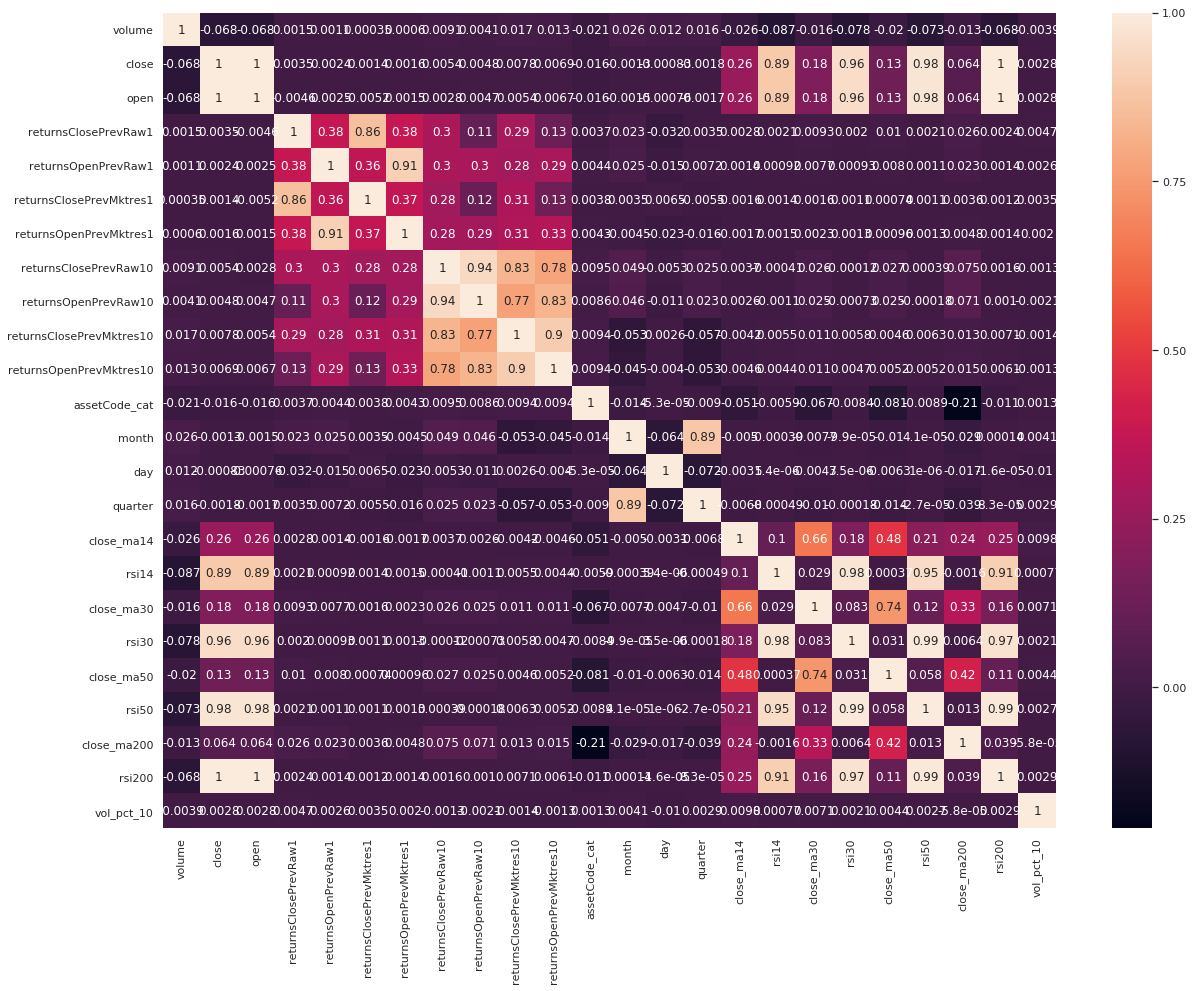

In [43]:
corr_matrix = X_train_sample.corr()
sns.set(rc={'figure.figsize':(20, 15)})
_ = sns.heatmap(corr_matrix, annot=True)

There seem to be a lot of highly correlated features.  Let’s drop features that are more than 90% correlated. 

In [44]:
# Correlated features to be dropped
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.90)]
print(f'Number of correlated features to drop: {len(to_drop)}')

Number of correlated features to drop: 7


In [45]:
to_drop

['open',
 'returnsOpenPrevMktres1',
 'returnsOpenPrevRaw10',
 'returnsOpenPrevMktres10',
 'rsi30',
 'rsi50',
 'rsi200']

In [46]:
X_train_sample.drop(to_drop, axis=1, inplace=True)
X_val_sample.drop(to_drop, axis=1, inplace=True)

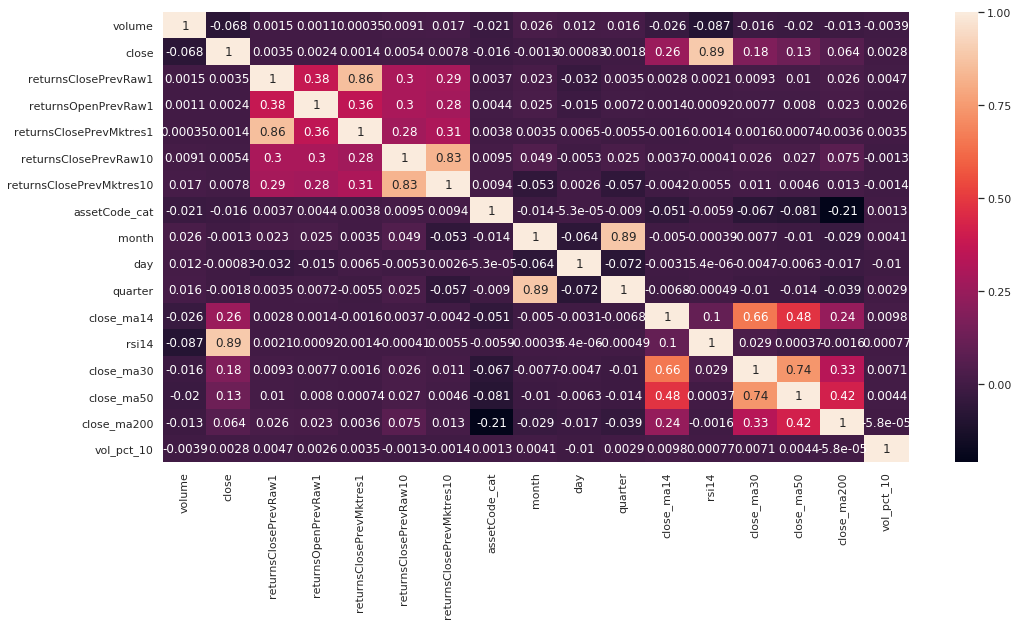

In [47]:
corr_matrix = X_train_sample.corr()
sns.set(rc={'figure.figsize':(16.7,8.27)})
_ = sns.heatmap(corr_matrix, annot=True)

This looks much better.

In [48]:
rfc = ensemble.RandomForestClassifier(n_estimators=30, min_samples_leaf=100, max_features=0.5, n_jobs=-1, random_state=23)
%time rfc.fit(X_train_sample, y_train_sample)

CPU times: user 52.6 s, sys: 20 ms, total: 52.6 s
Wall time: 13.8 s


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=0.5, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=100, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=-1,
            oob_score=False, random_state=23, verbose=0, warm_start=False)

In [49]:
print_accuracy(rfc, X_train_sample, y_train_sample, X_val_sample, y_val_sample)

Training Accuracy Score:  0.69553125
Validation Accuracy Score:  0.531575


After dropping 7 features, our accuracy hasn't really been affected.

In [50]:
feature_importances = get_feature_imp(rfc, X_train_sample)
feature_importances

,importance
returnsClosePrevRaw10,0.119597
returnsClosePrevMktres10,0.114182
close,0.076727
rsi14,0.073290
assetCode_cat,0.072896
month,0.064383
close_ma14,0.063179
close_ma200,0.061431
close_ma30,0.060869
volume,0.057028


This looks more like what we would expect.

In [51]:
# Clear up some memory
del X_train_sample
del y_train_sample
del X_val_sample
del y_val_sample

## Time for Some News Data
----

Now, this DataFrame is a beast.  With over 9 million rows, I am coming close to running out of memory.

In [52]:
print(f'market_train_df: {market_train_df.shape}')
print(f'tmpAssetCode: {tmpAssetCode.shape}')
print(f'tmpMarketDates: {tmpMarketDates.shape}')

market_train_df: (4072746, 25)
tmpAssetCode: (4072746,)
tmpMarketDates: (4072746,)


In [53]:
# Add back the assetCode and time feature so we can join the 2 DataFrames
market_train_df['assetCode'] = tmpAssetCode
market_train_df['time'] = tmpMarketDates

# Save memory
del tmpAssetCode
del tmpMarketDates

In [54]:
market_train_df.head()

,volume,close,open,returnsClosePrevRaw1,returnsOpenPrevRaw1,returnsClosePrevMktres1,returnsOpenPrevMktres1,returnsClosePrevRaw10,returnsOpenPrevRaw10,returnsClosePrevMktres10,returnsOpenPrevMktres10,returnsOpenNextMktres10,assetCode_cat,month,day,quarter,close_ma14,rsi14,close_ma30,rsi30,close_ma50,rsi50,close_ma200,rsi200,vol_pct_10,assetCode,time
210,-0.320595,-0.624333,-0.619364,-0.014790,-0.002193,-0.009078,-0.001334,0.569265,0.005022,-0.010597,-0.001858,-0.019720,519,2,3,1,0.801070,-0.893949,0.107538,-0.921198,0.437214,-0.905992,0.310941,-0.593170,-1.287295,BRKL.O,20070201
211,-0.252896,-0.608016,-0.603406,0.140628,-0.002153,-0.009078,-0.001334,0.022130,-0.001998,-0.010597,-0.001858,0.095959,521,2,3,1,0.723691,-0.872722,0.065596,-0.900116,0.332536,-0.885322,0.302989,-0.572530,-1.343687,BRKS.O,20070201
212,-0.247280,0.342588,0.328260,0.328803,-0.001087,-0.009078,-0.001334,-0.141523,-0.001130,-0.010597,-0.001858,0.023426,523,2,3,1,0.581115,0.344102,0.108580,0.314505,0.400780,0.309950,0.320802,0.627138,-1.330259,BRL.N,20070201
213,-0.260990,-0.261353,-0.266880,0.309876,0.000210,-0.009078,-0.001334,0.198477,-0.000800,-0.010597,-0.001858,-0.008698,525,2,3,1,0.562763,-0.413096,0.132845,-0.445324,0.415000,-0.441792,0.267058,-0.135608,-1.340783,BRO.N,20070201
214,-0.331453,-0.044984,-0.051916,0.318267,0.002477,-0.009078,-0.001334,1.130727,0.010385,-0.010597,-0.001858,0.003512,527,2,3,1,0.563652,-0.125396,0.101074,-0.165215,0.243229,-0.167850,0.260240,0.137767,-1.222726,BRS.N,20070201


In [55]:
news_train_df['time'] = news_train_df.time.dt.strftime("%Y%m%d").astype(int)
news_train_df['assetCode'] = news_train_df['assetCodes'].map(lambda x: list(eval(x))[0])

# determine the proportion of the news item discussing the asset
news_train_df['coverage'] = news_train_df['sentimentWordCount'] / news_train_df['wordCount']

# relative position of the first mention in the item
news_train_df['position'] = news_train_df['firstMentionSentence'] / news_train_df['sentenceCount']

Here I am creating a few NLP features.

*sentimentWordCount* is the number of lexical tokens in the sections of the item text that are deemed relevant to the asset. This can be used in conjunction with *wordCount* to determine the proportion of the news item discussing the asset.

*sentenceCount* and *firstMentionSentence* are used to determine to determine the relative position of the first mention in the item.

In [56]:
news_train_df.head()

,time,sourceTimestamp,firstCreated,sourceId,headline,urgency,takeSequence,provider,subjects,audiences,bodySize,companyCount,headlineTag,marketCommentary,sentenceCount,wordCount,assetCodes,assetName,firstMentionSentence,relevance,sentimentClass,sentimentNegative,sentimentNeutral,sentimentPositive,sentimentWordCount,noveltyCount12H,noveltyCount24H,noveltyCount3D,noveltyCount5D,noveltyCount7D,volumeCounts12H,volumeCounts24H,volumeCounts3D,volumeCounts5D,volumeCounts7D,assetCode,coverage,position
0,20070101,2007-01-01 04:29:32+00:00,2007-01-01 04:29:32+00:00,e58c6279551b85cf,China's Daqing pumps 43.41 mln tonnes of oil i...,3,1,RTRS,"{'ENR', 'ASIA', 'CN', 'NGS', 'EMRG', 'RTRS', '...","{'Z', 'O', 'OIL'}",1438,1,,False,11,275,"{'0857.HK', '0857.F', '0857.DE', 'PTR.N'}",PetroChina Co Ltd,6,0.235702,-1,0.500739,0.419327,0.079934,73,0,0,0,0,0,0,0,3,6,7,0857.DE,0.265455,0.545455
1,20070101,2007-01-01 07:03:34+00:00,2007-01-01 07:03:34+00:00,5a31c4327427f63f,"FEATURE-In kidnapping, finesse works best",3,1,RTRS,"{'FEA', 'CA', 'LATAM', 'MX', 'INS', 'ASIA', 'I...","{'PGE', 'PCO', 'G', 'ESN', 'MD', 'PCU', 'DNP',...",4413,1,FEATURE,False,55,907,{'STA.N'},Travelers Companies Inc,8,0.447214,-1,0.600082,0.345853,0.054064,62,1,1,1,1,1,1,1,3,3,3,STA.N,0.068357,0.145455
2,20070101,2007-01-01 11:29:56+00:00,2007-01-01 11:29:56+00:00,1cefd27a40fabdfe,PRESS DIGEST - Wall Street Journal - Jan 1,3,1,RTRS,"{'RET', 'ENR', 'ID', 'BG', 'US', 'PRESS', 'IQ'...","{'T', 'DNP', 'PSC', 'U', 'D', 'M', 'RNP', 'PTD...",2108,2,PRESS DIGEST,False,15,388,"{'WMT.DE', 'WMT.N'}",Wal-Mart Stores Inc,14,0.377964,-1,0.450049,0.295671,0.254280,67,0,0,0,0,0,0,0,5,11,17,WMT.DE,0.172680,0.933333
3,20070101,2007-01-01 12:08:37+00:00,2007-01-01 12:08:37+00:00,23768af19dc69992,PRESS DIGEST - New York Times - Jan 1,3,1,RTRS,"{'FUND', 'FIN', 'CA', 'SFWR', 'INS', 'PUB', 'B...","{'T', 'DNP', 'PSC', 'U', 'D', 'M', 'RNP', 'PTD...",1776,6,PRESS DIGEST,False,14,325,"{'GOOG.O', 'GOOG.OQ', 'GOOGa.DE'}",Google Inc,13,0.149071,-1,0.752917,0.162715,0.084368,83,0,0,0,0,0,0,0,5,13,15,GOOG.O,0.255385,0.928571
4,20070101,2007-01-01 12:08:37+00:00,2007-01-01 12:08:37+00:00,23768af19dc69992,PRESS DIGEST - New York Times - Jan 1,3,1,RTRS,"{'FUND', 'FIN', 'CA', 'SFWR', 'INS', 'PUB', 'B...","{'T', 'DNP', 'PSC', 'U', 'D', 'M', 'RNP', 'PTD...",1776,6,PRESS DIGEST,False,14,325,{'XMSR.O'},XM Satellite Radio Holdings Inc,11,0.149071,-1,0.699274,0.209360,0.091366,102,0,0,0,0,0,0,0,0,0,0,XMSR.O,0.313846,0.785714


In [57]:
# get rid of some features from news data
news_drops = ['sourceTimestamp','firstCreated','sourceId','takeSequence','firstMentionSentence',
            'headlineTag','subjects','audiences',
            'assetName', 'assetCodes']

news_train_df.drop(news_drops, axis=1, inplace=True)

Here we are dropping a few seemingly unnecessary features.  *sourceTimestamp* and *firstCreated* are essentially the same things and *sourceId* is a unique value for each row.

## TF-IDF

One of the features on the news DataFrame is the “headline” feature.  I thought I would experiment with tf-idf vectors here.

In [58]:
v = TfidfVectorizer(stop_words='english')
tfidf = v.fit_transform(news_train_df['headline'])

# Average across to get a scalar from the vector
tfidf_mean = tfidf.mean(axis=1)
del tfidf

In [59]:
news_train_df['tfidf_mean'] = tfidf_mean
news_train_df.drop(['headline'], axis=1, inplace=True)
del tfidf_mean

In [60]:
news_train_df.head()

,time,urgency,provider,bodySize,companyCount,marketCommentary,sentenceCount,wordCount,relevance,sentimentClass,sentimentNegative,sentimentNeutral,sentimentPositive,sentimentWordCount,noveltyCount12H,noveltyCount24H,noveltyCount3D,noveltyCount5D,noveltyCount7D,volumeCounts12H,volumeCounts24H,volumeCounts3D,volumeCounts5D,volumeCounts7D,assetCode,coverage,position,tfidf_mean
0,20070101,3,RTRS,1438,1,False,11,275,0.235702,-1,0.500739,0.419327,0.079934,73,0,0,0,0,0,0,0,3,6,7,0857.DE,0.265455,0.545455,0.000010
1,20070101,3,RTRS,4413,1,False,55,907,0.447214,-1,0.600082,0.345853,0.054064,62,1,1,1,1,1,1,1,3,3,3,STA.N,0.068357,0.145455,0.000008
2,20070101,3,RTRS,2108,2,False,15,388,0.377964,-1,0.450049,0.295671,0.254280,67,0,0,0,0,0,0,0,5,11,17,WMT.DE,0.172680,0.933333,0.000009
3,20070101,3,RTRS,1776,6,False,14,325,0.149071,-1,0.752917,0.162715,0.084368,83,0,0,0,0,0,0,0,5,13,15,GOOG.O,0.255385,0.928571,0.000009
4,20070101,3,RTRS,1776,6,False,14,325,0.149071,-1,0.699274,0.209360,0.091366,102,0,0,0,0,0,0,0,0,0,0,XMSR.O,0.313846,0.785714,0.000009


In [61]:
# aggregate -> combine news reports for same assets on same day
newsgp = news_train_df.groupby(['time','assetCode'], sort=False).aggregate(np.mean).reset_index()
del news_train_df

In [62]:
ts_df = market_train_df.merge(newsgp, how='left', left_on=['time', 'assetCode'], right_on=['time', 'assetCode'], 
                      suffixes=("", '_y'))

del market_train_df

Above we simply grouped the news data by *time* and *assetCode*, ran aggregate to get the averages of the data for a given day and then joined to the market data on *time* and *assetCode* features.

In [63]:
print(f'ts_df: {ts_df.shape}')
ts_df.head()

ts_df: (4072746, 52)


,volume,close,open,returnsClosePrevRaw1,returnsOpenPrevRaw1,returnsClosePrevMktres1,returnsOpenPrevMktres1,returnsClosePrevRaw10,returnsOpenPrevRaw10,returnsClosePrevMktres10,returnsOpenPrevMktres10,returnsOpenNextMktres10,assetCode_cat,month,day,quarter,close_ma14,rsi14,close_ma30,rsi30,close_ma50,rsi50,close_ma200,rsi200,vol_pct_10,assetCode,time,urgency,bodySize,companyCount,marketCommentary,sentenceCount,wordCount,relevance,sentimentClass,sentimentNegative,sentimentNeutral,sentimentPositive,sentimentWordCount,noveltyCount12H,noveltyCount24H,noveltyCount3D,noveltyCount5D,noveltyCount7D,volumeCounts12H,volumeCounts24H,volumeCounts3D,volumeCounts5D,volumeCounts7D,coverage,position,tfidf_mean
0,-0.320595,-0.624333,-0.619364,-0.014790,-0.002193,-0.009078,-0.001334,0.569265,0.005022,-0.010597,-0.001858,-0.019720,519,2,3,1,0.801070,-0.893949,0.107538,-0.921198,0.437214,-0.905992,0.310941,-0.593170,-1.287295,BRKL.O,20070201,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-0.252896,-0.608016,-0.603406,0.140628,-0.002153,-0.009078,-0.001334,0.022130,-0.001998,-0.010597,-0.001858,0.095959,521,2,3,1,0.723691,-0.872722,0.065596,-0.900116,0.332536,-0.885322,0.302989,-0.572530,-1.343687,BRKS.O,20070201,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-0.247280,0.342588,0.328260,0.328803,-0.001087,-0.009078,-0.001334,-0.141523,-0.001130,-0.010597,-0.001858,0.023426,523,2,3,1,0.581115,0.344102,0.108580,0.314505,0.400780,0.309950,0.320802,0.627138,-1.330259,BRL.N,20070201,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-0.260990,-0.261353,-0.266880,0.309876,0.000210,-0.009078,-0.001334,0.198477,-0.000800,-0.010597,-0.001858,-0.008698,525,2,3,1,0.562763,-0.413096,0.132845,-0.445324,0.415000,-0.441792,0.267058,-0.135608,-1.340783,BRO.N,20070201,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,-0.331453,-0.044984,-0.051916,0.318267,0.002477,-0.009078,-0.001334,1.130727,0.010385,-0.010597,-0.001858,0.003512,527,2,3,1,0.563652,-0.125396,0.101074,-0.165215,0.243229,-0.167850,0.260240,0.137767,-1.222726,BRS.N,20070201,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [64]:
ts_df.drop(['assetCode', 'time'], axis=1, inplace=True)

In [65]:
ts_df[newsgp.columns[2:].values] = ts_df[newsgp.columns[2:].values].fillna(value=0)
del newsgp

There will be many assets that will have many days without news data.  Let’s fill these NaN’s with a 0.

## Model Time

In [66]:
X_train_sample, y_train_sample, X_val_sample, y_val_sample = temploral_split(ts_df.iloc[-200000:], 'returnsOpenNextMktres10')

In [67]:
print(f'X_train_sample: {X_train_sample.shape}')
print(f'X_val_sample: {X_val_sample.shape}')

X_train_sample: (160000, 49)
X_val_sample: (40000, 49)


In [68]:
rfc = ensemble.RandomForestClassifier(n_estimators=30, min_samples_leaf=100, max_features=0.5, n_jobs=-1, random_state=23)
%time rfc.fit(X_train_sample, y_train_sample)

CPU times: user 1min 37s, sys: 48 ms, total: 1min 37s
Wall time: 25.8 s


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=0.5, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=100, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=-1,
            oob_score=False, random_state=23, verbose=0, warm_start=False)

In [69]:
print_accuracy(rfc, X_train_sample, y_train_sample, X_val_sample, y_val_sample)

Training Accuracy Score:  0.6997625
Validation Accuracy Score:  0.53645


In [70]:
feature_importances = get_feature_imp(rfc, X_train_sample)
feature_importances[0:30]

,importance
returnsOpenPrevMktres10,0.082746
returnsOpenPrevRaw10,0.079236
month,0.061304
returnsClosePrevRaw10,0.060350
returnsClosePrevMktres10,0.058017
assetCode_cat,0.051494
close_ma200,0.048169
volume,0.046338
close_ma14,0.045030
close_ma30,0.042122


The news data doesn’t seem to have added much to our model.  Perhaps I will have better luck with other models.  In the next notebook I will explore tuning my models further.